In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
import gymnasium
import sys
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import colorama

rocket_dir = os.path.split(os.path.abspath(os.curdir))[:-1]
rocket_src_dir = os.path.join(*rocket_dir, 'src')
rocket_dir = os.path.join(*rocket_dir)

print(f'Appending to sys.path:', [rocket_dir, rocket_src_dir])

sys.path.append(rocket_dir)
sys.path.append(rocket_src_dir)

from src.environments.frozen_env import make_frozen_env
from src.environments.minigrid_env import make_minigrid_env
from src.agents.IDEFICS_agent import IDEFICSAgent
from src.agents.LLaVa15_agent import LLaVa15Agent
from src.agents.Idefics2_agent import Idefics2Agent

pygame 2.5.2 (SDL 2.28.2, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Appending to sys.path: ['/mnt/llmdata/home/gbonetta/progetti/rocket', '/mnt/llmdata/home/gbonetta/progetti/rocket/src']


/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment FrozenLakeText-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Hanoi3Disk-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment Hanoi4Disk-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [2]:
env_id = "FrozenLakeText-v0"
#env_id = "MiniGrid-LavaGapS7-v0"

possible_action_list = "forward opt_back opt_left opt_right"
seed = 42

In [3]:
if 'frozen' in env_id.lower():
      envs = gymnasium.vector.SyncVectorEnv([
          make_frozen_env(
              "run_dir_prova",
              area=8,
              fov=1,
              seed=seed,
              size=400,
              is_slippery=False,
              fixed_orientation=True,
              save_video=False,
              save_stats=True,
              first_person=True)
        ])
else:
    envs = gymnasium.vector.SyncVectorEnv([
        make_minigrid_env(
            "run_dir_prova",
            env_id,
            possible_actions_list=possible_action_list.split(),
            fov=1,
            fixed_orientation=False,
            no_step_description=False,
            seed=seed,
            history_size=0,
            save_video=False,
            save_stats=False,
            first_person=False)
        ])
    
observation_space = envs.single_observation_space
action_enum = envs.envs[0].action_enum
list(action_enum)

/mnt/llmdata/home/gbonetta/miniconda3/miniconda/envs/crafter_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_enum to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_enum` for environment variables or `env.get_wrapper_attr('action_enum')` that will search the reminding wrappers.
  logger.warn(


[<FrozenActions.move_west: 'move west'>,
 <FrozenActions.move_south: 'move south'>,
 <FrozenActions.move_east: 'move east'>,
 <FrozenActions.move_north: 'move north'>]

In [ ]:
agent = IDEFICSAgent("HuggingFaceM4/idefics-9b-instruct",
                            action_enum=action_enum, 
                            is_lora=True,
                            padding_side="right", 
                            num_prompt_images=1, 
                            use_text_description=True, 
                            gradient_ckpt=False)
agent.critic.to('cuda')
agent.network.eval()
agent.critic.eval()

In [ ]:
agent = LLaVa15Agent("llava-hf/llava-1.5-7b-hf",
                            action_enum=action_enum, 
                            is_lora=True,
                            padding_side="right", 
                            num_prompt_images=1, 
                            use_text_description=True, 
                            gradient_ckpt=False)

agent.critic.to('cuda')
agent.network.eval()
agent.critic.eval()

In [4]:
agent = Idefics2Agent("HuggingFaceM4/idefics2-8b-chatty",
                    action_enum=action_enum, 
                    is_lora=True,
                    padding_side="right", 
                    num_prompt_images=1, 
                    use_text_description=True,
                    gradient_ckpt=False,
                    disable_adapters_for_generation=True)
agent.critic.to('cuda')
agent.network.eval()
agent.critic.eval()

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]
Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


trainable params: 186,613,760 || all params: 8,589,381,872 || trainable%: 2.1726


Sequential(
  (0): Linear(in_features=4096, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)

In [5]:
temperature = 'max_logit'
value_prompt_template= "I am the agent in this minigrid world. {} I have to avoid the traps and get to the goal! Where should i move now?"
action_template= " Now you should {}"

print(value_prompt_template.format(f"{colorama.Back.RED}<TEXT_DESCRIPTION>{colorama.Back.RESET}"))

I am the agent in this minigrid world. <TEXT_DESCRIPTION> I have to avoid the traps and get to the goal! Where should i move now?


------------------------------ STEP 0 ------------------------------


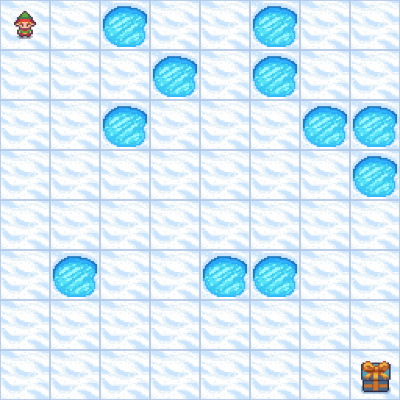

I am the agent in this minigrid world. I took action noop.
I see:
- a wall 1 steps to my west.
- a wall 1 steps to my north.
- the goal 14 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move west


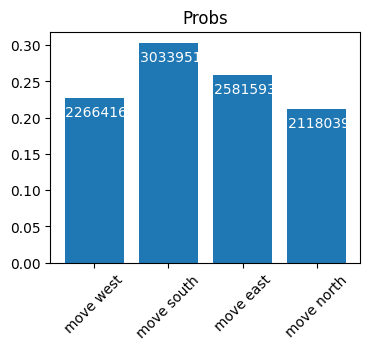

------------------------------ STEP 1 ------------------------------


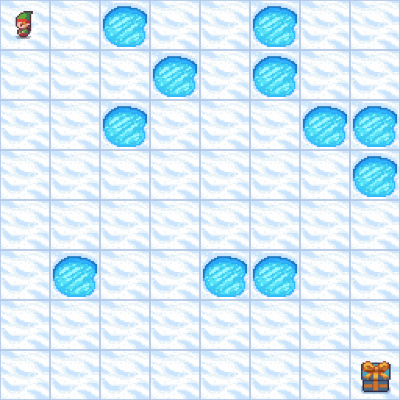

I am the agent in this minigrid world. I took action move west.
I see:
- a wall 1 steps to my west.
- a wall 1 steps to my north.
- the goal 14 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move north


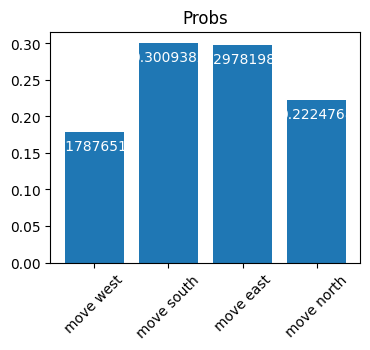

------------------------------ STEP 2 ------------------------------


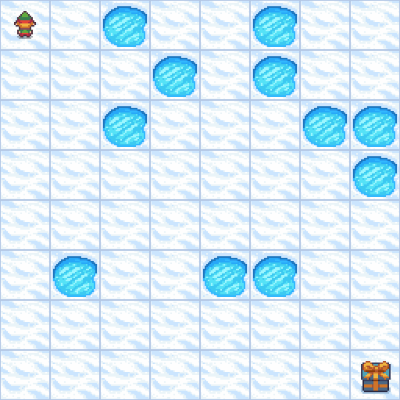

I am the agent in this minigrid world. I took action move north.
I see:
- a wall 1 steps to my west.
- a wall 1 steps to my north.
- the goal 14 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move south


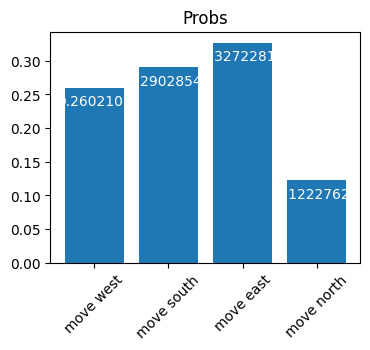

------------------------------ STEP 3 ------------------------------


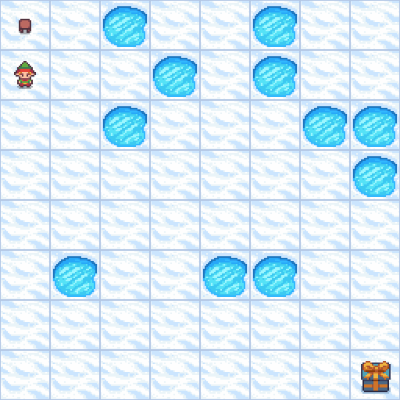

I am the agent in this minigrid world. I took action move south.
I see:
- a wall 1 steps to my west.
- the goal 13 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move north


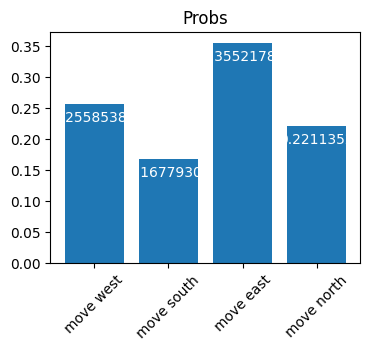

------------------------------ STEP 4 ------------------------------


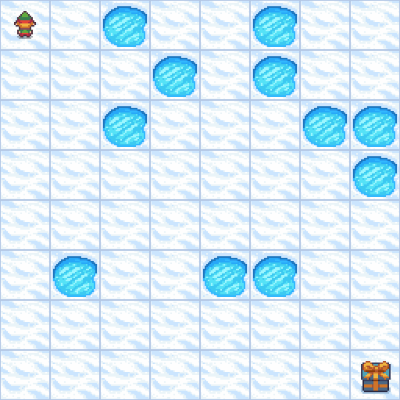

I am the agent in this minigrid world. I took action move north.
I see:
- a wall 1 steps to my west.
- a wall 1 steps to my north.
- the goal 14 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move south


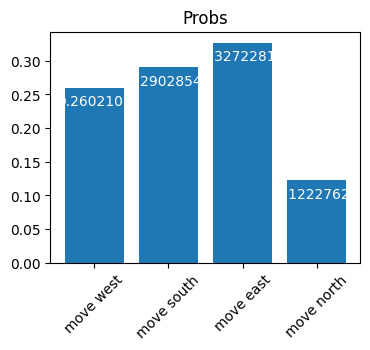

------------------------------ STEP 5 ------------------------------


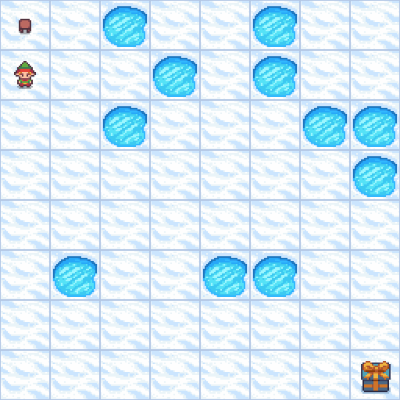

I am the agent in this minigrid world. I took action move south.
I see:
- a wall 1 steps to my west.
- the goal 13 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move south


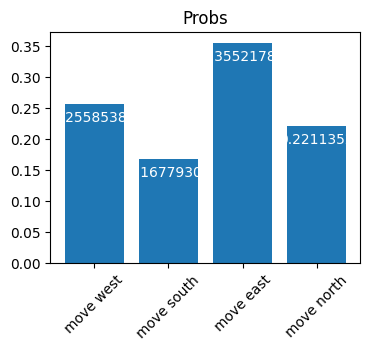

------------------------------ STEP 6 ------------------------------


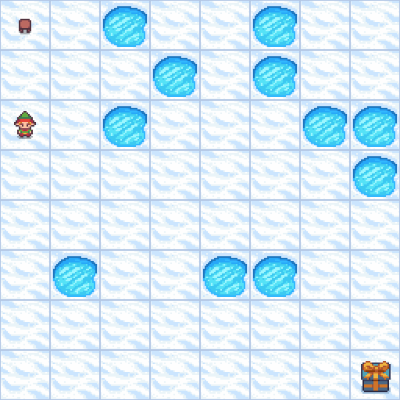

I am the agent in this minigrid world. I took action move south.
I see:
- a wall 1 steps to my west.
- the goal 12 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move west


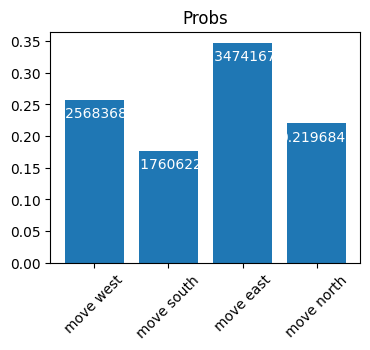

------------------------------ STEP 7 ------------------------------


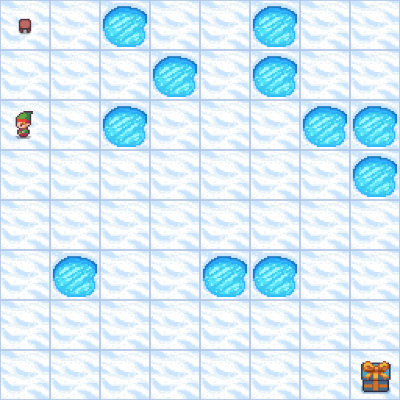

I am the agent in this minigrid world. I took action move west.
I see:
- a wall 1 steps to my west.
- the goal 12 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move west


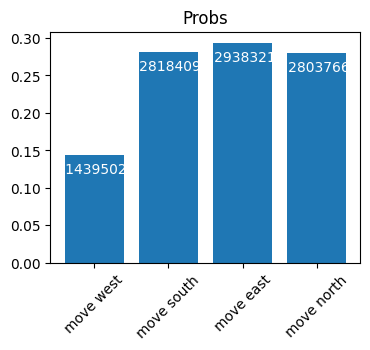

------------------------------ STEP 8 ------------------------------


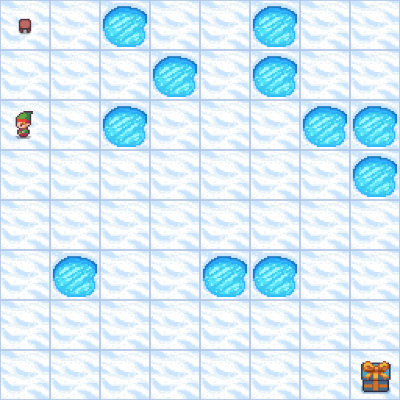

I am the agent in this minigrid world. I took action move west.
I see:
- a wall 1 steps to my west.
- the goal 12 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move south


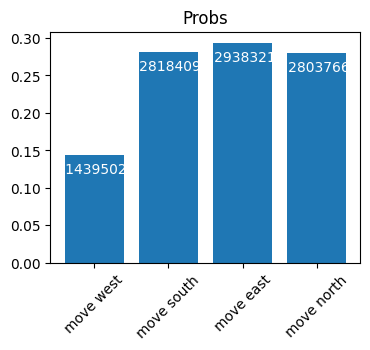

------------------------------ STEP 9 ------------------------------


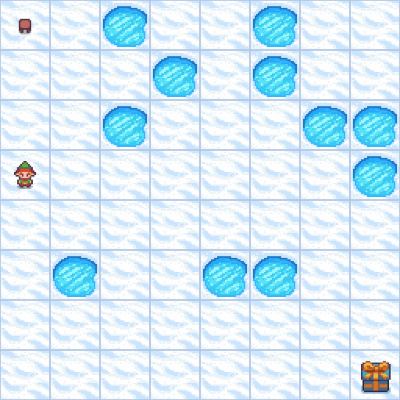

I am the agent in this minigrid world. I took action move south.
I see:
- a wall 1 steps to my west.
- the goal 11 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move west


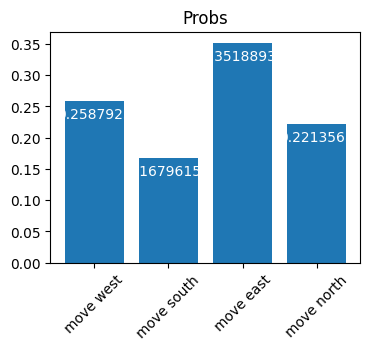

------------------------------ STEP 10 ------------------------------


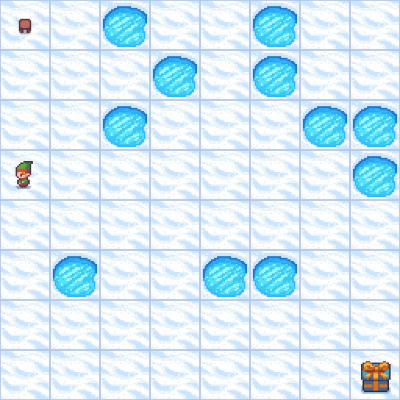

I am the agent in this minigrid world. I took action move west.
I see:
- a wall 1 steps to my west.
- the goal 11 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move east


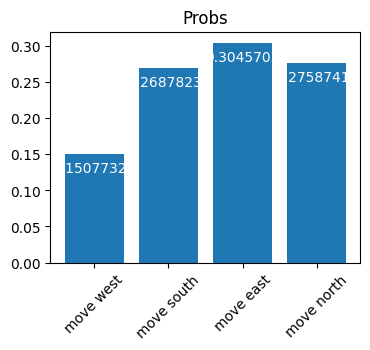

------------------------------ STEP 11 ------------------------------


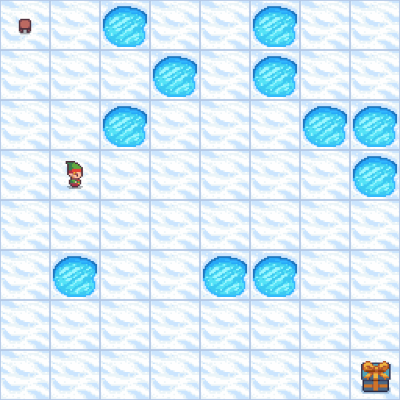

I am the agent in this minigrid world. I took action move east.
I see:
- the goal 10 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move north


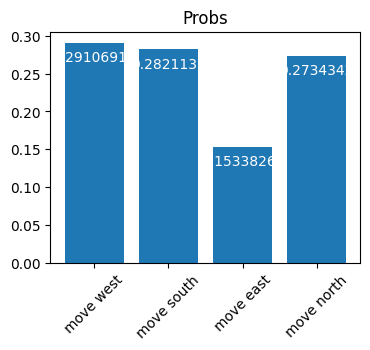

------------------------------ STEP 12 ------------------------------


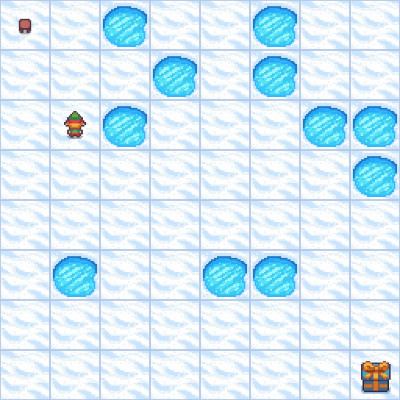

I am the agent in this minigrid world. I took action move north.
I see:
- a trap 1 steps to my east.
- the goal 11 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move east


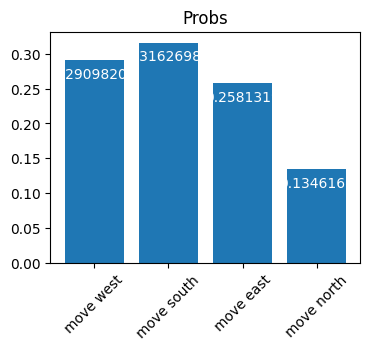

...........................................................................
.............................. EPISODE ENDED ..............................
...........................................................................
------------------------------ STEP 1 ------------------------------


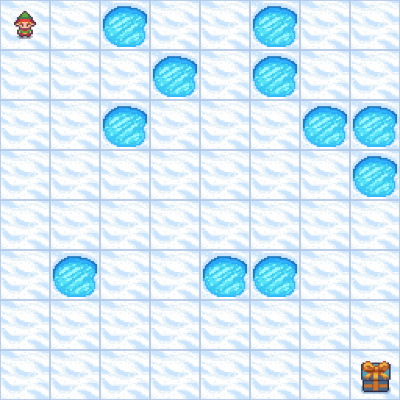

I am the agent in this minigrid world. I took action noop.
I see:
- a wall 1 steps to my west.
- a wall 1 steps to my north.
- the goal 14 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move west


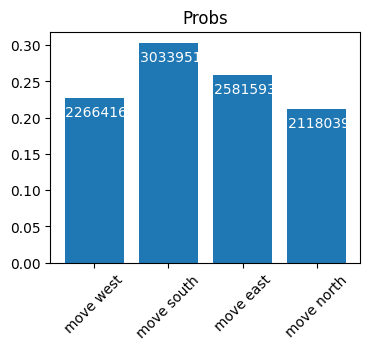

------------------------------ STEP 2 ------------------------------


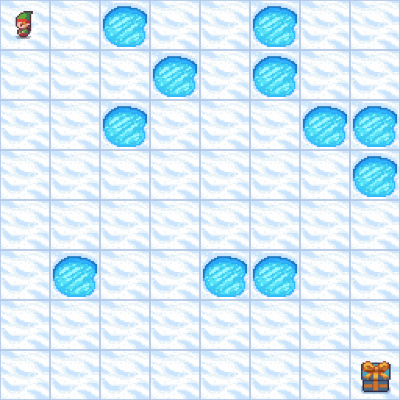

I am the agent in this minigrid world. I took action move west.
I see:
- a wall 1 steps to my west.
- a wall 1 steps to my north.
- the goal 14 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move south


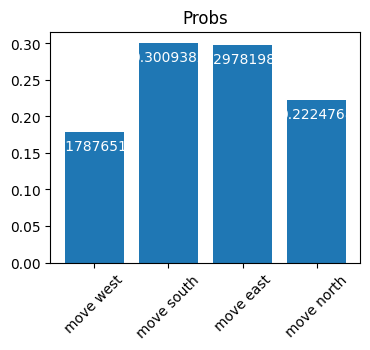

------------------------------ STEP 3 ------------------------------


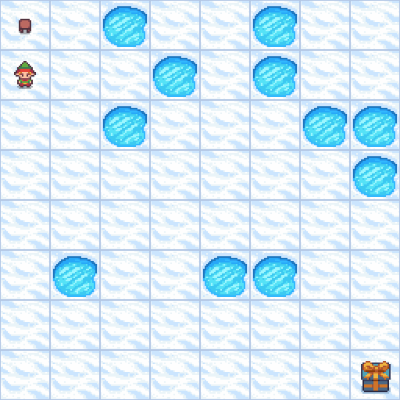

I am the agent in this minigrid world. I took action move south.
I see:
- a wall 1 steps to my west.
- the goal 13 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move east


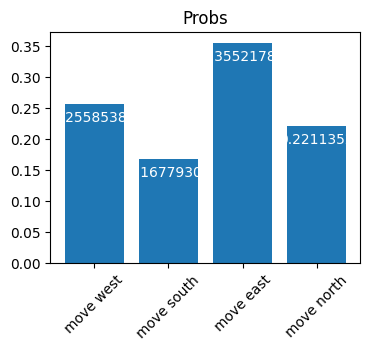

------------------------------ STEP 4 ------------------------------


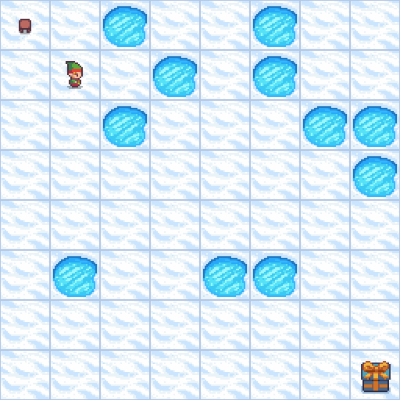

I am the agent in this minigrid world. I took action move east.
I see:
- the goal 12 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move east


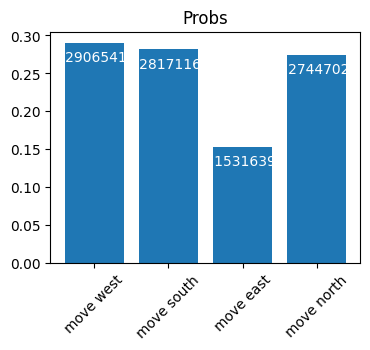

------------------------------ STEP 5 ------------------------------


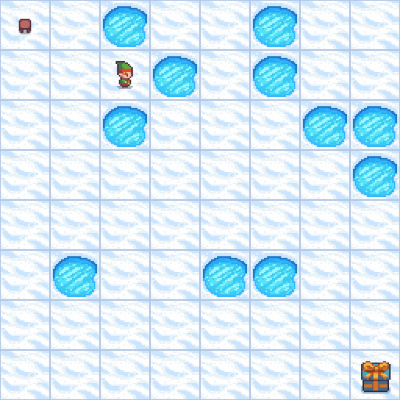

I am the agent in this minigrid world. I took action move east.
I see:
- a trap 1 steps to my north.
- a trap 1 steps to my east.
- a trap 1 steps to my south.
- the goal 11 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move east


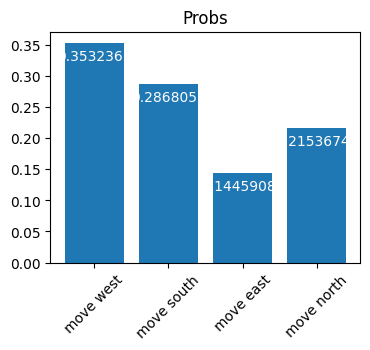

...........................................................................
.............................. EPISODE ENDED ..............................
...........................................................................
------------------------------ STEP 1 ------------------------------


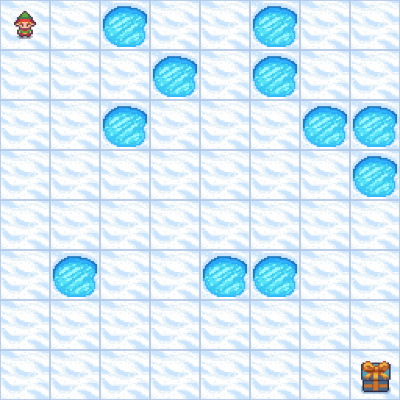

I am the agent in this minigrid world. I took action noop.
I see:
- a wall 1 steps to my west.
- a wall 1 steps to my north.
- the goal 14 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move south


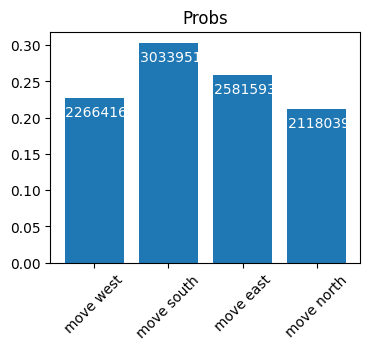

------------------------------ STEP 2 ------------------------------


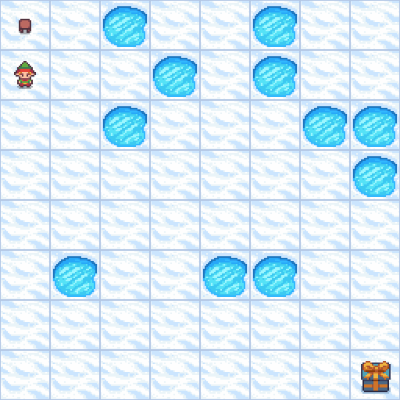

I am the agent in this minigrid world. I took action move south.
I see:
- a wall 1 steps to my west.
- the goal 13 steps to my south-east. I have to avoid the traps and get to the goal! Where should i move now?

Chosen action: move south


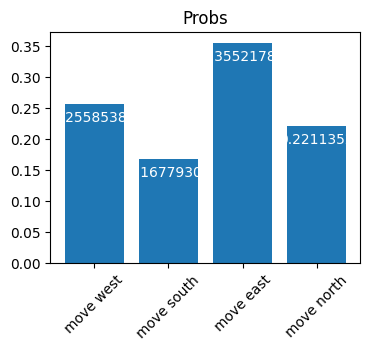

In [7]:
next_obs, infos = envs.reset(seed=seed)
next_obs = torch.Tensor(next_obs).to('cuda')
next_text_obs = infos.get('obs', [None])

max_steps = 20

step = 0
episode_step = 0

while step < max_steps:
    with torch.no_grad():
        res = agent.get_action_and_value(next_obs, 
                                         value_prompt_template=value_prompt_template,
                                         action_template=action_template,
                                         text_description=next_text_obs, 
                                         temperature=temperature, 
                                         normalization_by_words=True,
                                         advanced_action_matching=False)
    action, action_logits = res['action'], res['action_logits']
    action = action.cpu().numpy()

    print('-' * 30 + f" STEP {episode_step} " + '-' * 30)

    to_pil = transforms.ToPILImage()
    pil_image = to_pil(transforms.functional.invert(next_obs[0].permute(2, 0, 1)))
    display(pil_image)

    next_obs, reward, terminations, truncations, infos = envs.step(action)
    
    print(value_prompt_template.format(next_text_obs[0].strip()))
    print(f"\nChosen action: {colorama.Back.RED}{list(action_enum)[action[0]].value}")
    
    action_probs = torch.softmax(action_logits[0], dim=-1).cpu().numpy()
    plt.figure(figsize=(4, 3))        
    plt.title('Probs')
    plt.bar(range(len(action_probs)), action_probs)
    plt.xticks(range(len(action_probs)), [a.value for a in action_enum], rotation=45)
    for i, v in enumerate(action_probs):
        plt.gca().text(i, v - 0.01, str(v), color='white', verticalalignment='top', horizontalalignment='center')
    plt.show()        
    
    if terminations[0] or truncations[0]:
        s = '.' * 30 + " EPISODE ENDED " + '.' * 30
        print(colorama.Back.YELLOW + colorama.Fore.BLACK + '.' * len(s) + '\n' + s + '\n' + '.' * len(s) + colorama.Back.RESET + colorama.Fore.RESET)
        episode_step = 0
    
    next_text_obs = infos.get('obs', [None])
    next_obs = torch.Tensor(next_obs).to('cuda')
    step += 1
    episode_step += 1